# Enlazar Drive y dependencias



In [ ]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from pandas import DataFrame
from numpy import ones, zeros
from numpy.random import permutation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Concatenate, LSTM, Reshape, UpSampling1D, Conv1D, BatchNormalization, LeakyReLU, Flatten, Dense
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from google.colab import files #import csv file(Dataset) 
files.upload()

Saving A6.csv to A6.csv


{'A6.csv': b'Carbo,Tiempo,Tiempo_F,Insulina,Glucosa,Ingesta\r\nIngesta1,0,0,8.605478196,115.5723067,2000\r\nIngesta1,1,1,8.605478196,115.5726408,2000\r\nIngesta1,2,2,8.605478196,115.5745192,2000\r\nIngesta1,3,3,8.605478196,115.5803025,2000\r\nIngesta1,4,4,8.605478196,115.593383,2000\r\nIngesta1,5,5,8.605478196,115.6179854,2000\r\nIngesta1,6,6,8.605478196,115.6589632,2000\r\nIngesta1,7,7,8.605478196,115.7216185,2000\r\nIngesta1,8,8,8.605478196,115.8115477,2000\r\nIngesta1,9,9,8.605478196,115.9345142,2000\r\nIngesta1,10,10,8.605478196,116.0963422,2000\r\nIngesta1,11,11,8.605478196,116.30283,2000\r\nIngesta1,12,12,8.605478196,116.5596785,2000\r\nIngesta1,13,13,8.605478196,116.8724336,2000\r\nIngesta1,14,14,8.605478196,117.2464392,2000\r\nIngesta1,15,15,2.605478196,117.6867969,0\r\nIngesta1,16,16,2.605478196,118.1982544,0\r\nIngesta1,17,17,2.605478196,118.784709,0\r\nIngesta1,18,18,2.605478196,119.4487319,0\r\nIngesta1,19,19,2.605478196,120.1914992,0\r\nIngesta1,20,20,2.605478196,121.01293

# Lectura de datos

In [ ]:
# READ CSV 
pd.options.display.max_columns=150

# Read in the paciente data csv - keep only the columns we need, in this case: Time, glucose, intake e insulin
df=pd.read_csv('A6.csv', encoding='utf-8', usecols=['Carbo','Tiempo_F','Tiempo','Glucosa','Ingesta','Insulina'])

# Show a snaphsot of data
dfsn=df.copy()

# Organizacion de los datos.


In [ ]:
df2=df[['Carbo','Tiempo','Ingesta','Insulina','Glucosa' ]].copy()
muestras = 512
# Transpose dataframe 
df_glucosa = df2.pivot(index=['Carbo'], columns='Tiempo')['Glucosa']
df_insulina = df2.pivot(index=['Carbo'], columns='Tiempo')['Insulina']
df_ingesta = df2.pivot(index=['Carbo'], columns='Tiempo')['Ingesta']
df_glucosa.shape

############################### Transpose dataframe 

df2sn_pivot=df2.pivot(index=['Carbo'], columns='Tiempo')['Glucosa']
df2sn_pivot1=df2.pivot(index=['Carbo'], columns='Tiempo')['Insulina']
df2sn_pivot2=df2.pivot(index=['Carbo'], columns='Tiempo')['Ingesta']

##############################
df3sn=np.transpose(df2sn_pivot)
df4sn=np.transpose(df2sn_pivot1)

In [ ]:
# Obtener el último valor de cada muestra como una serie de Pandas para cada DataFrame
last_glucosa = df_glucosa.iloc[:, -1]
last_insulina = df_insulina.iloc[:, -1]
last_ingesta = df_ingesta.iloc[:, -1]

# Replicar los últimos valores 32 veces para obtener nuevas series de Pandas para cada DataFrame
new_last_glucosa = pd.concat([last_glucosa] * 32, axis=1)
new_last_insulina = pd.concat([last_insulina] * 32, axis=1)
new_last_ingesta = pd.concat([last_ingesta] * 32, axis=1)


# Definir nombres de columna para las 32 columnas vacías
new_columns = [f'{i}' for i in range(479,511)]
#print(new_columns)
# Agregar 32 columnas vacías con nombres de columna específicos
df_glucosa = df_glucosa.reindex(columns=[*df_glucosa.columns, *new_columns])
df_insulina = df_insulina.reindex(columns=[*df_insulina.columns, *new_columns])

# Concatenar las nuevas series de Pandas con los DataFrames originales para obtener la forma (42, 512) para cada DataFrame

df_glucosa.iloc[:, -32:] = new_last_glucosa
df_insulina.iloc[:, -32:] = new_last_insulina



# Grafica de los datos

In [ ]:
def plot_df(df2graph, muestras, data='glucosa'):
  # Plot levels of glucosa for each patient!
  fig = go.Figure()
  for Paciente in df2graph.index:
      fig.add_trace(go.Scatter(x=df2graph.loc[Paciente, :][0:muestras].index, 
                              y=df2graph.loc[Paciente, :][0:muestras].values,
                              mode='lines',
                              name=Paciente,
                              opacity=0.8,
                              line=dict(width=1)
                              ))

  # Change chart background color
  fig.update_layout(dict(plot_bgcolor = 'white'), showlegend=True)
  if data == 'glucosa':
    unidades = 'mg'
  elif data == 'insulina':
    unidades = 'ml'
  else:
    unidades = 'IDA'

  # Update axes lines
  fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                  zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                  showline=True, linewidth=1, linecolor='black',
                  title='muestras'
                  )

  fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                  zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                  showline=True, linewidth=1, linecolor='black',
                  title=unidades
                  )

  # Set figure title
  fig.update_layout(title=dict(text=f"Comportamiento de {data}", font=dict(color='black')))

  fig.show()

In [ ]:
plot_df(df_glucosa,muestras,'glucosa')
plot_df(df_ingesta,muestras,'ingesta')
plot_df(df_insulina,muestras,'insulina')

# Pre-procesamiento de los datos
1. Speracion 70/30




```
# Tiene formato de código
```

# podemos quitar la instruccion de X_Glu y X_ins,  quitar todo el [:,:512] y verificar que las columnas sean 512 con un print 'print(X_Ins.shape)'

In [ ]:
# Normalización de df_glucosa
X_Glu = df_glucosa.iloc[:,:512].values
X_min_glu = (X_Glu.min()).min()
X_max_glu = (X_Glu.max()).max()
X_norm_glu = (X_Glu - X_min_glu) / (X_max_glu - X_min_glu)

# Normalización de df_Insulina
X_Ins = df_insulina.iloc[:,:512].values
X_min_ins = (X_Ins.min()).min()
X_max_ins = (X_Ins.max()).max()
X_norm_ins = (X_Ins - X_min_ins) / (X_max_ins - X_min_ins)

# Crear un nuevo DataFrame con las columnas correspondientes para la glucosa e insulina normalizada
df_glucosa_norm = pd.DataFrame(X_norm_glu, columns=df_glucosa.columns[:512], index=df_glucosa.index)
df_insulina_norm = pd.DataFrame(X_norm_ins, columns=df_glucosa.columns[:512], index=df_glucosa.index)

# separar el conjunto de datos 70/30, y convertirlos en array.
# Dividir df_glucosa y df_insulina en conjuntos de entrenamiento y prueba
X_train_glu, X_test_glu = train_test_split(df_glucosa_norm.values[:, :], test_size=0.3, random_state=42, shuffle=False)
X_train_ins, X_test_ins = train_test_split(df_insulina_norm.values[:, :], test_size=0.3, random_state=42, shuffle=False)

total_datos_train, _ = X_train_glu.shape # 70%, 512
total_datos_test, _ = X_test_glu.shape   # 30%, 512

df_glucosa_norm_copia = df_glucosa_norm.copy()
df_insulin_norm_copia = df_insulina_norm.copy()

# No se mezclan para tener un buen seguimiento de los datos, y vuelve y se separan los datos 70/30
_, X_val_glu = train_test_split(df_glucosa_norm_copia.values[:, :], test_size=0.3,shuffle=False)
_, X_val_ins = train_test_split(df_insulin_norm_copia.values[:, :], test_size=0.3,shuffle=False)

# Glucosa train y valid, copiados para usar 512 muestras, ..._d2 se pasa al discriminador
X_train_glu_d2 = copy.copy(X_train_glu)
X_train_ins_d2 = copy.copy(X_train_ins)
X_test_glu_d2 = copy.copy(X_test_glu)
X_test_ins_d2 = copy.copy(X_test_ins)

In [ ]:
X_min = (df_glucosa.min()).min()
X_max = (df_glucosa.max()).max()
# Restaurar la escala original
df_restored = df_glucosa_norm * (X_max - X_min) + X_min

In [ ]:
plot_df(df_restored,muestras)
plot_df(df_glucosa_norm,muestras)

In [ ]:
#plot_df(df_glucosa,muestras,'glucosa')
#plot_df(df_glucosa_norm,muestras,'glucosa')

# Definicion de los modelos y funciones auxiliares

In [ ]:
def crear_genenerador(input_size=16, lt=None):
  # Input layer
  input_glu = Input(shape=(input_size, 1), batch_size=lt, name='input_glu_G')
  input_ins = Input(shape=(input_size, 1), batch_size=lt, name='input_ins_G')
  
  # Concatenate inputs
  concat = Concatenate(axis=2)([input_glu, input_ins])
  
  # Generador UN
  leak=0.4
  # Bloque 1
  conv1 = Conv1D(64, 4, padding='same')(concat)
  norm1 = BatchNormalization()(conv1)
  activ1 = LeakyReLU(leak)(norm1)
  conv2 = Conv1D(64, 4, padding='same')(activ1)
  norm2 = BatchNormalization()(conv2)
  activ2 = LeakyReLU(leak)(norm2)

  # Bloque 2
  conv3 = Conv1D(32, 4, padding='same')(activ2)
  norm3 = BatchNormalization()(conv3)
  activ3 = LeakyReLU(leak)(norm3)
  conv4 = Conv1D(128, 4, padding='same')(activ3)
  norm4 = BatchNormalization()(conv4)
  activ4 = LeakyReLU(leak)(norm4)

  # Bloque 3
  conv5 = Conv1D(32, 4, padding='same')(activ4)
  norm5 = BatchNormalization()(conv5)
  activ5 = LeakyReLU(leak)(norm5)
  conv6 = Conv1D(32, 4, padding='same')(activ5)
  norm6 = BatchNormalization()(conv6)
  activ6 = LeakyReLU(leak)(norm6)

  # Bloque 4
  lstm1 = LSTM(64, return_sequences=True)(activ6)
  lstm2 = LSTM(64, return_sequences=True)(lstm1)

  # Salida
  output = Conv1D(512, input_size, activation='sigmoid')(lstm2)
  output = Reshape((512, 1),batch_size=lt)(output)

  # Crear modelo
  model = Model(inputs=[input_glu, input_ins], outputs=output, name='generador')
  plot_model(model, to_file='Generador_Model.png', show_shapes=True, show_layer_names=True, show_dtype=True)

  return model


def crear_discriminador(lt=None):
  leak2=0.4
  input_glu = Input(shape=(512,1), batch_size=lt, name='input_glu_D')
  input_ins = Input(shape=(512,1), batch_size=lt, name='input_ins_D')

  # Concatenar inputs
  concat = Concatenate(axis=2)([input_glu, input_ins])
  conv = Conv1D(64, 4, strides=2, padding='same')(concat)
  activ = LeakyReLU(leak2)(conv)
  num_layers = 6
  for i in range(num_layers - 1):
    conv = Conv1D(2 ** (i + 6), 4, strides=2, padding='same')(activ)
    activ = LeakyReLU(leak2)(conv)

  # Aplanar capas convolucionales
  flat = Flatten()(activ)

  # Salida
  output = Dense(int(flat.shape[1]*(0.25)), activation='sigmoid')(flat)
  num_dense = 5
  for i in range(num_dense -1):
    output = Dense(int(output.shape[1]*(0.25)), activation='sigmoid')(output)
    
  # Crear modelo
  model = Model(inputs=[input_glu, input_ins], outputs=output, name='discriminador')

  # Compilar modelo
  optimizer = RMSprop(learning_rate=1e-3, momentum=0.5)
  model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse'])
  plot_model(model,to_file='Discriminador_Model.png',show_shapes=True,show_layer_names=True,show_dtype=True)
  return model

def crear_gan(generador, discriminador, input_size=16, lt=None):
  # Capa de entrada
  input_glu = Input(shape=(input_size, 1), batch_size=lt, name='input_glu_gan')
  input_ins = Input(shape=(input_size, 1), batch_size=lt, name='input_ins_gan')
  
  # Entrada para D
  input_glu2 = Input(shape=(512, 1), batch_size=lt, name='input_glu_d512')
  # D no se entrena en la GAN
  discriminador.trainable= False

  # Glucosa Generada
  glu_gen = generador([input_glu,input_ins])
  # Luego pasan por el Discriminador
  out_dis = discriminador([input_glu2,glu_gen])
  # se crea el modelo GAN
  gan = Model([input_glu,input_ins,input_glu2],[glu_gen,out_dis])

  optimizador = RMSprop(learning_rate=2e-3,momentum=0.5)
  gan.compile(loss='mse', optimizer=optimizador)
  plot_model(gan,to_file='Gan_Model.png',show_shapes=True,show_layer_names=True,show_dtype=True)
  return gan 
  
def MuestrasVerdaderas(X_train_glu, X_train_ins, X_train_glu_d2, X_train_ins_d2, idx, Lote, n_muestras, out_d):
  # Crear vectores con las dimensiones de los datos
  Real_glu_lt = np.zeros(shape=(Lote, n_muestras[0], 1))
  Real_ins_lt = np.zeros(shape=(Lote, n_muestras[0], 1))
  Real_glu_d2 = np.zeros(shape=(Lote, n_muestras[1], 1))
  Real_ins_d2 = np.zeros(shape=(Lote, n_muestras[1], 1))
  # Seleccionar los datos en el tamaño del lote
  for i in range(Lote):
    Real_glu_lt[i, :, 0] = X_train_glu[idx[i], :n_muestras[0]]#initial
    Real_ins_lt[i, :, 0] = X_train_ins[idx[i], :n_muestras[0]]
    Real_glu_d2[i, :, 0] = X_train_glu_d2[idx[i], :n_muestras[1]]#512
    Real_ins_d2[i, :, 0] = X_train_ins_d2[idx[i], :n_muestras[1]]
  # Crear etiquetas de muestras verdaderas
  y_real = np.ones(shape=(Lote,out_d))
  
  return Real_glu_lt, Real_ins_lt, Real_glu_d2, Real_ins_d2, y_real

def MuestrasFalsas(g_model, X_train_glu, X_train_ins,idx, Lote, n_muestras, out_d):
  # Crear vectores con las dimensiones de los datos
  Real_glu = np.zeros(shape=(Lote, n_muestras, 1))
  Real_ins = np.zeros(shape=(Lote, n_muestras, 1))
  
  # Seleccionar los datos en el tamaño del lote
  for i in range(Lote):
    Real_glu[i, :, 0] = X_train_glu[idx[i], :n_muestras]
    Real_ins[i, :, 0] = X_train_ins[idx[i], :n_muestras]
  # Generar muestras falsas
  Y_glu_fake = g_model.predict_on_batch([Real_glu, Real_ins])
  
  # Crear etiquetas para las muestras falsas
  Y_fake = np.zeros(shape=(Lote,out_d)) * -1
  return Y_glu_fake, Y_fake

def train():
  half_batch = int(lt/2)
  out_d = discriminador.output_shape[1]
  samples= initial_features, 512

  # Inicializar listas para almacenar las funciones de pérdida
  d_loss_prom, d_loss_r, d_loss_f, gan_loss = list(), list(), list(), list()
  for k in range(epocas):
    # Se permutan todas los datos
    idx_permutation = permutation(total_datos_train)
    for i in range(batch_x_epoca):
      # Genereamos un vector de posiciones del tamaño del lote.
      idx = idx_permutation[i*lt:(i+1)*lt]
      # Generamos muestras reales con medio lote
      Real_glu, Real_ins, Real_glu_d2, Real_ins_d2, y_real = MuestrasVerdaderas(X_train_glu, X_train_ins, X_train_glu_d2, X_train_ins_d2, idx, half_batch, samples, out_d)
      # Generamos muestras falsas con medio lote, y 512, Recordar que la entrada de G es 16 o 32.
      Y_glu_fake, Y_fake = MuestrasFalsas(generador, X_train_glu, X_train_ins, idx, half_batch, samples[0], out_d)
      for _ in range(n_dis):
        # Entrenamos con datos reales y 512 porque es D
        d_loss_real = discriminador.train_on_batch([Real_glu_d2, Real_ins_d2],y_real)
        d_loss_r.append(d_loss_real)
        # Entrenamos con muetras Falsas desde la predicción del G
        d_loss_fake = discriminador.train_on_batch([Y_glu_fake, Real_ins_d2],Y_fake)
        d_loss_f.append(d_loss_fake)
        d_loss_iter = 0.5 * np.add(d_loss_real, d_loss_fake)
      # Entrenamos al Generador dentro de la GAN, Ahora con el tamaño del batch
      Real_glu, Real_ins, Real_glu_d2, Real_ins_d2, y_real = MuestrasVerdaderas(X_train_glu, X_train_ins, X_train_glu_d2,X_train_ins_d2, idx, lt, samples, out_d)
      gan_loss_iter = gan.train_on_batch([Real_glu,Real_ins,Real_glu_d2],[Real_glu_d2,y_real])
      # Almacenar las funciones de pérdida de esta iteración
      d_loss_prom.append(d_loss_iter)
      gan_loss.append(gan_loss_iter)
    print(f'Epocas: {i}/{epocas+1}, loss D prom: {d_loss_iter}, loss GAN: {gan_loss_iter}')
    if not os.path.exists('/content/Modelos'):
      os.mkdir('/content/Modelos')
    g_model_save = '/content/Modelos/Model_%02d.h5' % (k)
    generador.save(g_model_save)
    # Ahora revisamos el estado mediante las epocas
    # Crear vectores con las dimensiones de los datos de inferencia
    Real_glu_input = np.zeros(shape=(X_val_glu.shape[0], initial_features, 1))
    Real_ins_input = np.zeros(shape=(X_val_ins.shape[0], initial_features, 1))
    # Comparativa de salida
    Real_glu_out = np.zeros(shape=(X_val_glu.shape[0], 512, 1))
    list_ = list(range(X_val_glu.shape[0]))
    # Seleccionar los datos en el tamaño de la entrada
    for i in range(X_val_glu.shape[0]):
      Real_glu_input[i, :, 0] = X_val_glu[list_[i], :initial_features]
      Real_ins_input[i, :, 0] = X_val_ins[list_[i], :initial_features]
      Real_glu_out[i, :, 0] = X_val_glu[list_[i], :512]
    
    # Generar muestras desde el modelo 
    Y_glu_generada = generador.predict_on_batch([Real_glu_input, Real_ins_input])
    muestra = 0   
    X_min = df_glucosa.iloc[:,:512].min()
    X_max = df_glucosa.iloc[:,:512].max()
    
    # Obtener las 512 características reales y generadas para la muestra seleccionada
    glucosa_real_muestra = Real_glu_out[muestra,:,0] * (X_max - X_min) + X_min
    glucosa_gene_muestra = Y_glu_generada[muestra,:,0] * (X_max - X_min) + X_min

    # Graficar ambas señales en una misma figura
    plt.plot(glucosa_real_muestra, label='Real')
    plt.plot(glucosa_gene_muestra, label='Generada')

    # Agregar leyenda para cada una de las señales
    plt.legend()

    # Agregar etiquetas a los ejes
    plt.xlabel('muestras')
    plt.ylabel(f'mg de Glucosa')

    # Guardar la figura
    if not os.path.exists('/content/Graficas'):
      os.mkdir('/content/Graficas')
    name = '/content/Graficas/Comparativa_Glucosa%02d.png' %(k)
    plt.savefig(name)
    plt.close()
    
  d_loss_prom  = np.array(d_loss_prom)
  d_loss_r = np.array(d_loss_r)
  d_loss_f = np.array(d_loss_f)
  gan_loss = np.array(gan_loss)
  return np.array(d_loss_prom), np.array(d_loss_r), np.array(d_loss_f), np.array(gan_loss), generador

# Entrenamiento

In [ ]:
initial_features = 16
generador = crear_genenerador(initial_features)
discriminador = crear_discriminador()
gan = crear_gan(generador,discriminador)
######################################
##### PARAMETROS DE ENTRENAMIENTO#####
epocas = 10
lt = 4 #batch
n_dis = 1
######################################
batch_x_epoca = int(total_datos_train/lt)

# Se invoca el entrenamiento y se entrena
d_loss_prom, d_loss_r, d_loss_f, gan_loss, generador = train()

Epocas: 6/11, loss D prom: [0.50641537 0.50641537 0.28844079], loss GAN: [0.2935835123062134, 0.12857381999492645, 0.16500967741012573]


Epocas: 6/11, loss D prom: [0.50490841 0.50490841 0.28981295], loss GAN: [0.17239831387996674, 0.009825500659644604, 0.16257281601428986]


Epocas: 6/11, loss D prom: [0.50421351 0.50421351 0.29117769], loss GAN: [0.16987209022045135, 0.008116702549159527, 0.16175538301467896]


Epocas: 6/11, loss D prom: [0.5037614  0.5037614  0.29239737], loss GAN: [0.16318058967590332, 0.0015354164643213153, 0.16164517402648926]


Epocas: 6/11, loss D prom: [0.50342721 0.50342721 0.29349043], loss GAN: [0.1684293895959854, 0.006502377800643444, 0.1619270145893097]


Epocas: 6/11, loss D prom: [0.50316632 0.50316632 0.29448633], loss GAN: [0.17066587507724762, 0.008238322101533413, 0.16242755949497223]


Epocas: 6/11, loss D prom: [0.50295979 0.50295979 0.29541447], loss GAN: [0.16748104989528656, 0.004440227523446083, 0.16304081678390503]


Epocas: 6/11, loss D prom: [0.50279209 0.50279209 0.29629044], loss GAN: [0.16726946830749512, 0.003565879538655281, 0.16370359063148499]


Epocas: 6/11, loss D prom: [0.50265464 0.50265464 0.29712678], loss GAN: [0.1649508774280548, 0.0005654991837218404, 0.1643853783607483]


Epocas: 6/11, loss D prom: [0.50253865 0.50253865 0.29792678], loss GAN: [0.17818525433540344, 0.01311514712870121, 0.16507010161876678]


In [ ]:
print(f'Retorno de D> {discriminador.metrics_names} Retorno GAN> {gan.metrics_names}')
# Esto  ayudara para que graficar las perdidas y metricas


Retorno de D> ['loss', 'mae', 'mse'] Retorno GAN> ['loss', 'generador_loss', 'discriminador_loss']


**ERROR**

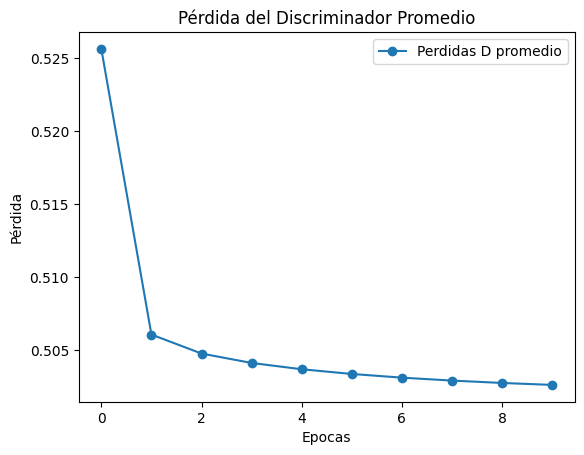

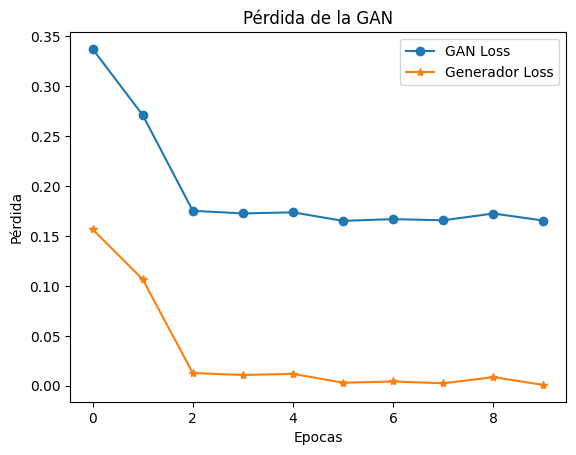

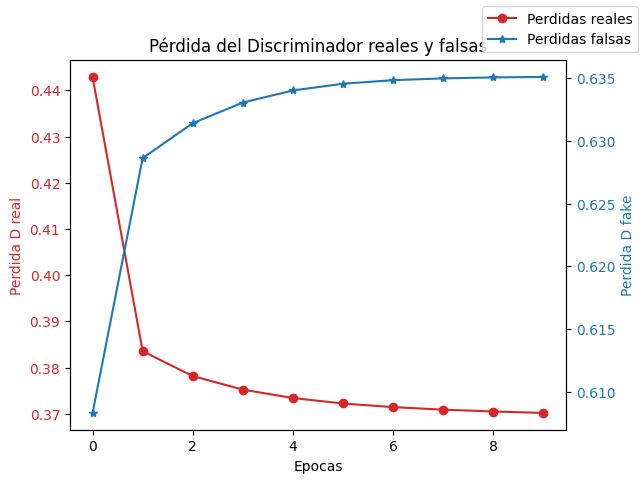

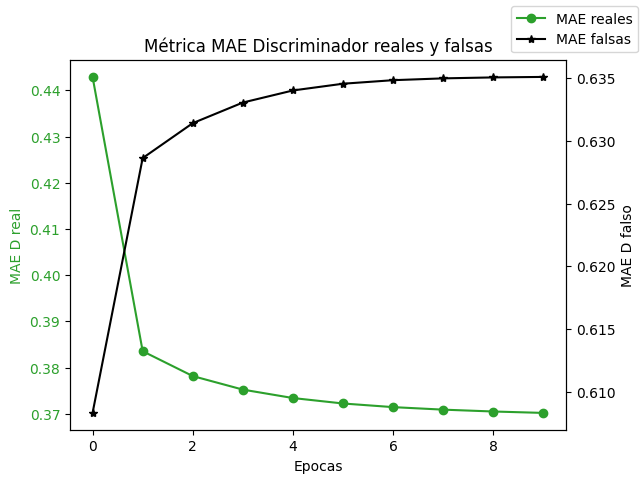

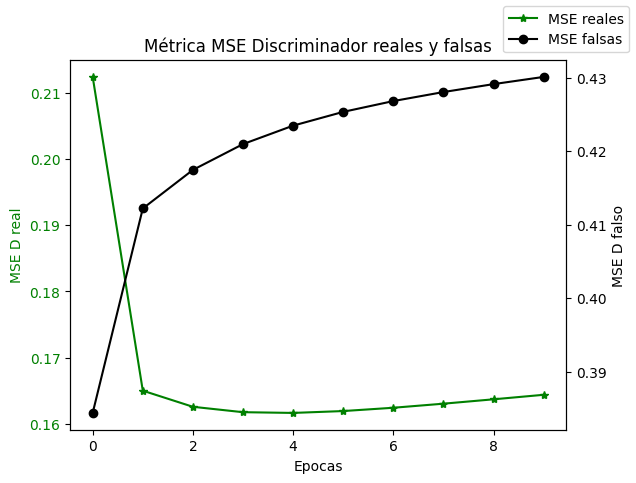

In [ ]:
def grafica_perdidas(iter=True):
  ''' 
  Iter> Argumento para cambiar la graficas de iteraciones a epocas, es decir menor cantidad de detalle visualmente
  '''
  steps = 1 if iter else batch_x_epoca
  x_ax = 'Iteraciones' if iter else 'Epocas'

  plt.plot(d_loss_prom[::steps,0], marker='o', label='Perdidas D promedio')
  plt.title('Pérdida del Discriminador Promedio')
  plt.xlabel(x_ax)
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

  # Graficar la pérdida de la GAN
  plt.plot(gan_loss[::steps,0], marker='o', label='GAN Loss')
  plt.plot(gan_loss[::steps,1], marker='*', label='Generador Loss')
  plt.title('Pérdida de la GAN')
  plt.xlabel(x_ax)
  plt.ylabel('Pérdida')
  plt.legend()
  plt.show()

  fig, ax1 = plt.subplots()

  # plot d_loss_r en el primer eje Y
  color = 'tab:red'
  ax1.set_xlabel(x_ax)
  ax1.set_ylabel('Perdida D real', color=color)
  ax1.plot(d_loss_r[::n_dis*steps,0], marker='o', label='Perdidas reales', color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  # crear un segundo eje Y para d_loss_f
  ax2 = ax1.twinx()

  # plot d_loss_f en el segundo eje Y
  color = 'tab:blue'
  ax2.set_ylabel('Perdida D fake', color=color)
  ax2.plot(d_loss_f[::n_dis*steps,0], marker='*', label='Perdidas falsas', color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  # crear leyendas individuales
  lines, labels = [], []
  for ax in [ax1, ax2]:
    axLines, axLabels = ax.get_legend_handles_labels()
    lines.extend(axLines)
    labels.extend(axLabels)

  # agregar las dos leyendas a la figura
  fig.legend(lines, labels, loc='upper right')
  plt.title('Pérdida del Discriminador reales y falsas')
  plt.show()

  fig, ax1 = plt.subplots()

  # plot d_loss_r en el primer eje Y
  color = 'tab:green'
  ax1.set_xlabel(x_ax)
  ax1.set_ylabel('MAE D real', color=color)
  ax1.plot(d_loss_r[::n_dis*steps,1], marker='o', label='MAE reales', color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  # crear un segundo eje Y para d_loss_f
  ax2 = ax1.twinx()

  # plot d_loss_f en el segundo eje Y
  color = 'k'
  ax2.set_ylabel('MAE D falso', color=color)
  ax2.plot(d_loss_f[::n_dis*steps,1], marker='*', label='MAE falsas', color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  # crear leyendas individuales
  lines, labels = [], []
  for ax in [ax1, ax2]:
    axLines, axLabels = ax.get_legend_handles_labels()
    lines.extend(axLines)
    labels.extend(axLabels)

  # agregar las dos leyendas a la figura
  fig.legend(lines, labels, loc='upper right')
  plt.title('Métrica MAE Discriminador reales y falsas')
  plt.show()

  fig, ax1 = plt.subplots()

  # plot d_loss_r en el primer eje Y
  color = 'g'
  ax1.set_xlabel(x_ax)
  ax1.set_ylabel('MSE D real', color=color)
  ax1.plot(d_loss_r[::n_dis*steps,2], marker='*', label='MSE reales', color=color)
  ax1.tick_params(axis='y', labelcolor=color)

  # crear un segundo eje Y para d_loss_f
  ax2 = ax1.twinx()

  # plot d_loss_f en el segundo eje Y
  color = 'k'
  ax2.set_ylabel('MSE D falso', color=color)
  ax2.plot(d_loss_f[::n_dis*steps,2], marker='o', label='MSE falsas', color=color)
  ax2.tick_params(axis='y', labelcolor=color)

  # crear leyendas individuales
  lines, labels = [], []
  for ax in [ax1, ax2]:
    axLines, axLabels = ax.get_legend_handles_labels()
    lines.extend(axLines)
    labels.extend(axLabels)

  # agregar las dos leyendas a la figura
  fig.legend(lines, labels, loc='upper right')
  plt.title('Métrica MSE Discriminador reales y falsas')
  plt.show()

# grafica_perdidas(True)
grafica_perdidas(False)

# Inferencia

In [ ]:
# No se mezclan para tener un buen seguimiento de los datos, y vuelve y se separan los datos 70/30
_, X_test_glu = train_test_split(df_glucosa_norm_copia.values[:, :], test_size=0.3,shuffle=False)

# Dividir df_insulina en conjuntos de entrenamiento y prueba
_, X_test_ins = train_test_split(df_insulin_norm_copia.values[:, :], test_size=0.3,shuffle=False)

In [ ]:
def Inferencia(g_model, X_test_glu, X_test_ins):
  # Crear vectores con las dimensiones de los datos de inferencia
  Real_glu_input = np.zeros(shape=(X_test_glu.shape[0], initial_features, 1))
  Real_ins_input = np.zeros(shape=(X_test_ins.shape[0], initial_features, 1))
  # Comparativa de salida
  Real_glu_out = np.zeros(shape=(X_test_glu.shape[0], 512, 1))
  list_ = list(range(X_test_glu.shape[0]))
  # Seleccionar los datos en el tamaño de la entrada
  for i in range(X_test_glu.shape[0]):
    Real_glu_input[i, :, 0] = X_test_glu[list_[i], :initial_features]
    Real_ins_input[i, :, 0] = X_test_ins[list_[i], :initial_features]
    Real_glu_out[i, :, 0] = X_test_glu[list_[i], :512]
  # Generar muestras desde el modelo 
  Y_glu_generada = g_model.predict_on_batch([Real_glu_input, Real_ins_input])
  return Y_glu_generada, Real_glu_out

Gene 307.5832
Real 347.5275373
El área bajo la prediccion es 87885.75
El área bajo la curva real es:  92162.801029
El error calculado es:  -4.64075633688062 %


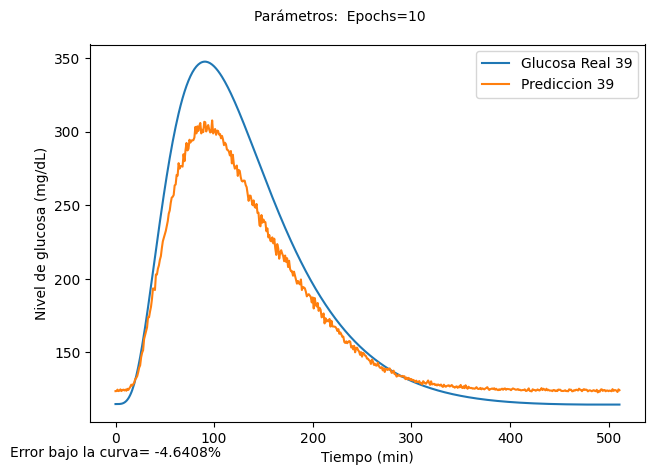

In [ ]:
glucosa_gene, glucosa_real = Inferencia(generador,X_test_glu, X_test_ins)

# orden=  [36 37 38 39 4 40 41 42 5 6 7  8  9]
# Muestra [0   1  2  3 4  5  6  7 8 9 10 11 12]
muestra = 3 #--> Seleccionamos la ingetsa 39.
Num_ingesta="39" # Acá defina el número de la ingesta a predecir!


Ingesta="Ingesta"+ Num_ingesta 
X_min = df['Glucosa'].min()
X_max = df['Glucosa'].max()

# Obtener las 512 características reales y generadas para la muestra seleccionada
glucosa_real_muestra = glucosa_real[muestra,:,0] * (X_max - X_min) + X_min
glucosa_gene_muestra = glucosa_gene[muestra,:,0] * (X_max - X_min) + X_min

# Graficar ambas señales en una misma figura
plt.plot(glucosa_real_muestra, label='Glucosa Real 39')
plt.plot(glucosa_gene_muestra, label='Prediccion 39')
  

# Agregar leyenda para cada una de las señales
plt.legend()

# Agregar etiquetas a los ejes
plt.xlabel("Tiempo (min)") # título del eje x
plt.ylabel("Nivel de glucosa (mg/dL)") # título del eje y
plt.suptitle(( f"Parámetros:  Epochs={epocas}"), fontsize=10)
# Mostrar la figura

plt.savefig('Comparativa de Glucosa.png')

print("Gene",glucosa_gene_muestra.max())
print("Real", glucosa_real_muestra.max())

area_p = np.sum(glucosa_gene_muestra)
print("El área bajo la prediccion es",area_p)
real=np.array(glucosa_real_muestra)
area_r=np.sum(real)
print("El área bajo la curva real es: ",area_r)
Err=((area_p-area_r)/area_r)*100
print("El error calculado es: ", Err, "%")

plt.tight_layout() # ajusta el espaciado de la gráfica
plt.text(0, dfsn['Glucosa'].max()*0.2, f"Error bajo la curva= {round(Err, 4)}%", ha='center', va='center')

plt.show()